In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline

import pandas as pd

import argparse
import ellc

import gatspy
from gatspy import datasets, periodic

In [2]:
## V-band

In [3]:
V = pd.read_csv('V1061GettysburgV.csv', sep=",", header=0)
#X = pd.read_csv('V1061.csv', sep=",", header=0 )
HJDV = V["HJD"]
magV = V["Delmag"]
print (V)

             HJD  Delmag
0    2452541.552   0.592
1    2452548.593   0.575
2    2452541.554   0.590
3    2452548.596   0.577
4    2452548.598   0.575
5    2452541.560   0.588
6    2452548.600   0.573
7    2452548.603   0.572
8    2452541.563   0.591
9    2452548.605   0.565
10   2452541.567   0.586
11   2452548.607   0.571
12   2452548.609   0.563
13   2452541.570   0.583
14   2452541.573   0.573
15   2452541.576   0.563
16   2452548.618   0.538
17   2452548.620   0.520
18   2452534.540   0.535
19   2452548.622   0.512
20   2452534.543   0.523
21   2452548.624   0.493
22   2452534.545   0.503
23   2452541.587   0.491
24   2452548.626   0.474
25   2452534.548   0.485
26   2452548.629   0.467
27   2452541.590   0.467
28   2452534.550   0.471
29   2452548.631   0.449
..           ...     ...
708  2452569.641   0.278
709  2452548.523   0.287
710  2452548.525   0.297
711  2452569.646   0.299
712  2452548.528   0.307
713  2452548.531   0.326
714  2452548.535   0.337
715  2452548.537   0.356


In [4]:
#  phase folded at 
#        http://vizier.cfa.harvard.edu/viz-bin/vizExec/Vgraph?J/ApJ/640/1018/./table3&P=2.35

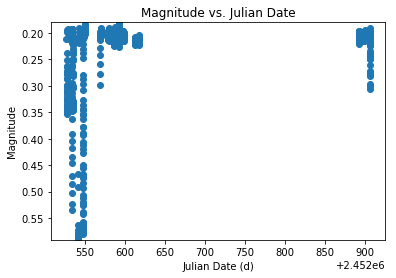

In [5]:
plt.plot (HJDV[1:], magV[1:], 'o')
plt.title ('Magnitude vs. Julian Date')
ymin=float(min(magV[1:]))
ymax=float(max(magV[1:]))
plt.ylim(ymax, ymin)
plt.xlabel('Julian Date (d)')
plt.ylabel ('Magnitude')


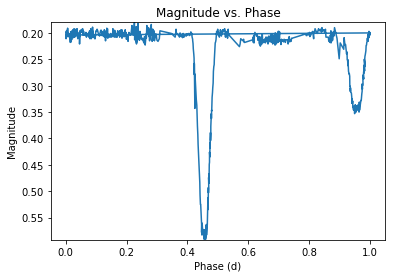

In [6]:
Period = 2.34665473 #days
PhaseV = (HJDV % Period)/ Period

plt.plot (PhaseV, magV, '-')
plt.title ('Magnitude vs. Phase')
ymin=float(min(magV))
ymax=float(max(magV))
plt.ylim(ymax, ymin)
plt.xlabel('Phase (d)')
plt.ylabel ('Magnitude')



##### Aaron's

#V1061 Cyg, Torres et al. (2006)
#http://adsabs.harvard.edu/abs/2006ApJ...640.1018T
#has data online in BVRI
#but has 3rd star, and paper is all about activity playing a role in the 2nd star

#see also test_lc.py for more comments

import numpy
import ellc
import matplotlib.pyplot as plt
import astropy
from astropy import units,constants
from astropy.io import ascii

def afromP(m1, m2, P):
  return (((P**2.) * constants.G * (m1 + m2) / (4*numpy.pi**2.))**(1./3.)).decompose().to(units.AU)


############## read in the data
Vobs = ascii.read('Torres2006_V1061Cyg_V.txt')

#from Torres' table 10
period = 2.34665473 * units.day
#t_zero = 2452015.89295 #*units.day (NOTE: they give the T0 value in MJD, but the data file has HJD)
t_zero = 2452015.9050 #this is the spectroscopic only result (and it fits better)
#note, eccentricity was fixed at zero, so we don't have to worry about it here


#from Torres' Table 11
m1 = 1.282 * units.solMass
m2 = 0.9315 * units.solMass
q = m2/m1 # = 0.7266 
r1 = 1.615 * units.solRad
r2 = 0.974 * units.solRad
Teff1 = 6180. * units.Kelvin
Teff2 = 5300. * units.Kelvin
logg1 = 4.129
logg2 = 4.430
L1 = (10.**0.533) * units.solLum
L2 = (10.**-0.173) * units.solLum
L3 = (10.**-0.153) * units.solLum
Mv1 = 3.456
Mv2 = 5.457
distance = 166.9*units.parsec

#this is given in Table 9
#for Gettysburg V
incl = 88.5 
r_1 = 0.1625
r_2 = 0.0970
#interestingly, r_1 and r_2 from Table 9 are not identical to the values I would calculate using the true radii.  This is likely because the star has a slightly different apparent radius in each filter (because of the optical depth)
#this is the fraction of the total light
I1 = 0.737
I2 = 0.119
I3 = 0.144
sbratio = 0.472 # = J
sigV = 0.0082

#try adding in the 3rd light
#Third light contribution relative to total flux from both stars at time t_zero excluding eclipse effects.
#light_3 = L3/(L1 + L2)
light_3 = I3

#calculate some additional necessary inputs for ellc
a = afromP(m1, m2, period)
#r_1 = (r1/a).decompose()
#r_2 = (r2/a).decompose()
#sbratio = (L2/r2**2.) / (L1/r1**2.)
#sbratio = (L2/(r_2*a)**2.) / (L1/(r_1*a)**2.)

#strip out the units here for input to ellc
pvalue = period.to(units.day).value
avalue = a.to(units.solRad).value

#convert the observations to phase (given the derived period from Torres)
phase = numpy.array([(tt % pvalue)/pvalue for tt in Vobs['HJD']])

############### create the ellc model
shape_1 = 'sphere'#'roche'#'poly1p5'
shape_2 = 'sphere'#'roche'#'poly1p5'

M_H = 0.0 #this is apparently unknown -- see Torres Section 5 : "No accurate estimate of the metallicity is available."

#limb darkening, using ellc.ldy 
ldy_V = ellc.ldy.LimbGravityDarkeningCoeffs('V')
a1_1, a2_1, a3_1, a4_1, y_1 = ldy_V(Teff1.to(units.Kelvin).value, logg1,  M_H)
a1_2, a2_2, a3_2, a4_2, y_2 = ldy_V(Teff2.to(units.Kelvin).value, logg2,  M_H)
 
#ld_1 = 'sqrt'
#ldc_1 = [a1_1, a2_1] 
#ld_2 = 'sqrt'
#ldc_2 = [a1_2, a2_2] 

#We need to use this to match the observations! 
ld_1 = 'claret'
ldc_1 = [a1_1, a2_1, a3_1, a4_1] 
ld_2 = 'claret'
ldc_2 = [a1_2, a2_2, a3_2, a4_2]

#for some reason, I need to sort the phase so that I can plot a line (that doesn't connect back on itself)
sphase = numpy.argsort(phase)
ellc_phase = phase[sphase]
ellc_t = Vobs['HJD'][sphase]
flux = ellc.lc(ellc_t, t_zero=t_zero, period=pvalue, #a=avalue, q=q,
               ld_1=ld_1, ldc_1=ldc_1, ld_2=ld_2, ldc_2=ldc_2,
               radius_1=r_1, radius_2=r_2, incl=incl, sbratio=sbratio,
               shape_1=shape_1, shape_2=shape_2, light_3=light_3)
#######               grid_1='fine', grid_2='fine')

#it looks like this is in "arbitrary units".  How can we convert to physical units?
#normalize the flux
#flux = flux/max(flux)

#convert to magnitude  
ellc_mag = -2.5*numpy.log10(flux)

#try to add on noise to simulate the observations
numpy.random.seed(seed = 1111)
ellc_mag_obs = [numpy.random.normal(loc=x, scale=sigV) for x in ellc_mag]

print ("period = ",period)
print ("semi-major axis = ",a)
print ("inclination = ",incl)
print ("mass1 = ",m1)
print ("radius1 = ",r1)
print ("radius1/a = ",r_1)
print ("luminosity1 = ",L1)
print ("Teff1 = ",Teff1)
print ("log(g)1 = ",logg1)
print ("mass2 = ",m2)
print ("radius2 = ",r2)
print ("radius2/a = ",r_2)
print ("luminosity2 = ",L2)
print ("Teff2 = ",Teff2)
print ("log(g)2 = ",logg2)
print ("surface brightness ratio = ",sbratio)
print ("mass ratio = ",q)
print ("light_3 = ",light_3)

#I think I need to normalize the observed mag to match up with ellc.  But maybe this has to do with the arbitrary units of ellc??
#Vsubtract = min(Vobs['mag'])
#maybe better to find a mean value out of eclipse
Vuse = numpy.where(phase < 0.4)[0]
Vsubtract = numpy.mean(Vobs['mag'][Vuse])
Vobs_plot = Vobs['mag'] - Vsubtract

plt.plot(ellc_phase, ellc_mag_obs,'o', label='ellc + noise', mfc='none')
plt.plot(phase, Vobs_plot,'.',label='observations')
plt.plot(ellc_phase, ellc_mag, label='ellc')
#plt.ylim(max(ellc_mag), min(ellc_mag))
#plt.ylim(max(Vobs['mag']), min(Vobs['mag']))
plt.ylim(max(numpy.append(Vobs_plot, ellc_mag)), min(numpy.append(Vobs_plot, ellc_mag)))
plt.xlabel("phase")
plt.ylabel("relative V magnitude")
plt.legend()

plt.show()



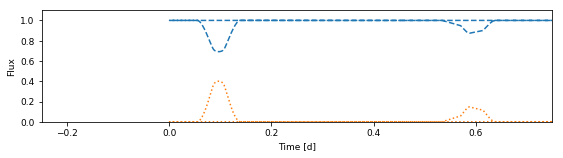

In [7]:
#lc_dat = np.loadtxt("NightfallCurve.dat")

#phase = lc_dat[:,1]
#flux = 10**(-0.4*lc_dat[:,4])  # V-band

#M_H == 0
#Teff1 == 6180
#Teff2 == 5300
#logg1 == 4.129
#logg2 == 4.430

ldy_V = ellc.ldy.LimbGravityDarkeningCoeffs('V')
a1_1, a2_1, a3_1, a4_1, y = ldy_V(6180, 4.129, 0)
a1_2, a2_2, a3_2, a4_2, y = ldy_V(5300, 4.430, 0)


# Note that star 1 is the star labelled Secondary in nightfall
Vt_zero = 2452526.632
period = 2.34665473
Vsbratio = 0.472
Vr_1 = 0.1625 
Vr_2 = 0.0970
Vincl = 88.5
light_3 = 0.144
a = 9.682
q = 0.7266
rotfac_1 = 1
rotfac_2 = 1
shape_1 = 'sphere'
shape_2 = 'sphere'
gdc_1 = -0.33
gdc_2 = -0.41
vsini_1 = 36
vsini_2 = 20
ld_1 = 'claret'
Vldc_1 = [a1_1, a2_1, a3_1, a4_1] #[0.50] # V-band coeffs from nightfall (using -Dv flag)
ld_2 = 'claret'
Vldc_2 = [a1_2, a2_2, a3_2, a4_2] #[0.60] # V-band coeffs from nightfall (using -Dv flag)
ecc = 0  # e>0 does not work in nightfall!
om  = 90
f_c = np.sqrt(ecc)*np.cos(om*np.pi/180.)
f_s = np.sqrt(ecc)*np.sin(om*np.pi/180.)

Vt = PhaseV*period
lcV = ellc.lc(Vt,t_zero=Vt_zero, period=period, a=a, q=q,
    ld_1=ld_1,ldc_1=Vldc_1,ld_2=ld_2,ldc_2=Vldc_2,
    radius_1=Vr_1, radius_2=Vr_2,incl=Vincl,sbratio=Vsbratio, 
    rotfac_1=rotfac_1, rotfac_2=rotfac_2, gdc_1=gdc_1, gdc_2=gdc_2,
    shape_1=shape_1,shape_2=shape_2, light_3=light_3, grid_1='default',grid_2='default') 

magnV = -2.5*np.log10(lcV)


fontsize=9
fig=plt.figure(1,figsize=(8,4))
fig=plt.figure(1)
plt.subplot(211)
plt.xlim([-0.25,0.75])
plt.ylim([0.0,1.1])
plt.plot(PhaseV, lcV, linestyle='--')
plt.plot(PhaseV,magnV, linestyle=':')
plt.xlabel("Time [d]",fontsize=fontsize)
plt.ylabel("Flux",fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)


plt.tight_layout()
plt.show()

In [8]:
noiseV = np.random.normal(0.00, 0.0082, 738)
magnV_noise = magnV + noiseV
#mean = 0.
#sigma = 0.0082
#tmp = np.random.normal(loc = mean, scale = sigma, size = 50)
#magn_noise_aaron = [np.random.normal(loc = x, scale = sigma) for x in magn]
#print(magn_noise_aaron)
#print(noise)
#print(np.array([1,2,3]) + np.array([4]))

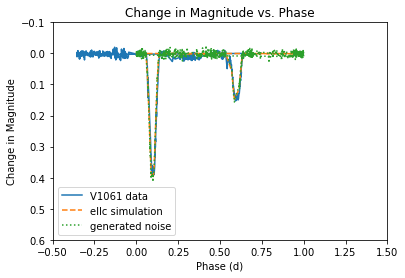

In [9]:
plt.plot(PhaseV - 0.355, magV - 0.2, '-', label = "V1061 data")
plt.plot(PhaseV, magnV, '--', label = "ellc simulation")
plt.plot (PhaseV, magnV_noise, ':', label = "generated noise")

#ax.plot(Phase - 0.355, mag - 0.2, color='c', linestyle = '-', label="V1061 data")
#ax.plot(Phase, magn, color='indigo', linestyle = '--', label="ellc simulation")
#ax.plot(Phase, magn_noise, color= 'darkslategray', linestyle = ':', label = "generated noise")

plt.title('Change in Magnitude vs. Phase' )
plt.xlim([-0.50,1.50])
plt.ylim([0.6,-0.1])

#ymin=float(min(mag))
#ymax=float(max(mag))
#plt.ylim(ymax, ymin)

plt.legend(loc = 'best')
plt.ylabel('Change in Magnitude')
plt.xlabel('Phase (d)')
plt.show()

In [10]:
## R-band
# phase-folded at 
#                http://vizier.cfa.harvard.edu/viz-bin/vizExec/Vgraph?J/ApJ/640/1018/./table6&P=2.35

In [11]:
R = pd.read_csv('V1061GettysburgR.csv', sep=",", header=0)
#X = pd.read_csv('V1061.csv', sep=",", header=0 )
HJDR = R["HJD"]
magR = R["Delmag"]
print (R)

             HJD  Delmag
0    2452541.552   0.389
1    2452548.594   0.377
2    2452541.554   0.392
3    2452548.596   0.368
4    2452548.598   0.376
5    2452541.560   0.388
6    2452548.601   0.378
7    2452548.603   0.376
8    2452541.564   0.392
9    2452548.605   0.369
10   2452541.567   0.383
11   2452548.607   0.373
12   2452541.570   0.384
13   2452541.573   0.375
14   2452548.616   0.354
15   2452541.577   0.357
16   2452548.618   0.343
17   2452548.620   0.329
18   2452534.540   0.336
19   2452548.622   0.319
20   2452534.543   0.322
21   2452548.625   0.306
22   2452534.546   0.313
23   2452541.587   0.306
24   2452548.627   0.293
25   2452534.548   0.296
26   2452548.629   0.278
27   2452541.590   0.278
28   2452534.551   0.283
29   2452548.631   0.267
..           ...     ...
709  2452569.641   0.104
710  2452548.523   0.096
711  2452548.526   0.118
712  2452569.646   0.125
713  2452548.528   0.139
714  2452548.531   0.148
715  2452548.535   0.151
716  2452548.538   0.166


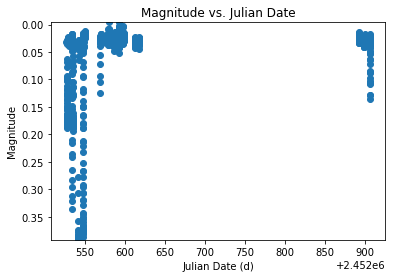

In [12]:
plt.plot (HJDR[1:], magR[1:], 'o')
plt.title ('Magnitude vs. Julian Date')
ymin=float(min(magR[1:]))
ymax=float(max(magR[1:]))
plt.ylim(ymax, ymin)
plt.xlabel('Julian Date (d)')
plt.ylabel ('Magnitude')


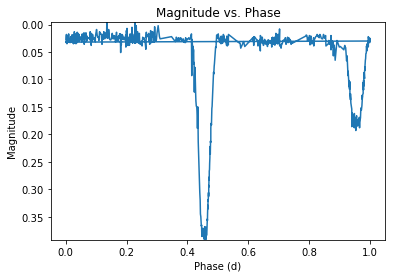

In [13]:
Period = 2.34665473 #days
PhaseR = (HJDR % Period)/ Period

plt.plot (PhaseR, magR, '-')
plt.title ('Magnitude vs. Phase')
ymin=float(min(magR))
ymax=float(max(magR))
plt.ylim(ymax, ymin)
plt.xlabel('Phase (d)')
plt.ylabel ('Magnitude')



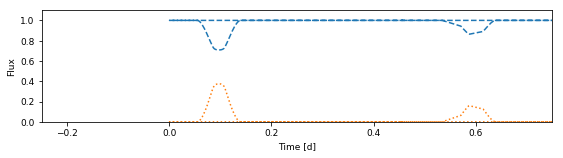

In [14]:
#M_H == 0
#Teff1 == 6180
#Teff2 == 5300
#logg1 == 4.129
#logg2 == 4.430

ldy_R = ellc.ldy.LimbGravityDarkeningCoeffs('R')
a1_1, a2_1, a3_1, a4_1, y = ldy_R(6180, 4.129, 0)
a1_2, a2_2, a3_2, a4_2, y = ldy_R(5300, 4.430, 0)


# Note that star 1 is the star labelled Secondary in nightfall
Rt_zero = 2452526.633
period = 2.34665473
Rsbratio = 0.525
Rr_1 = 0.1635 
Rr_2 = 0.0971
Rincl = 88.5
light_3 = 0.152
a = 9.681
q = 0.7266
rotfac_1 = 1
rotfac_2 = 1
shape_1 = 'sphere'
shape_2 = 'sphere'
gdc_1 = -0.33
gdc_2 = -0.41
vsini_1 = 36
vsini_2 = 20
ld_1 = 'claret'
Rldc_1 = [a1_1, a2_1, a3_1, a4_1] #[0.48] 
ld_2 = 'claret'
Rldc_2 = [a1_2, a2_2, a3_2, a4_2] #[0.54] 
ecc = 0  # e>0 does not work in nightfall!
om  = 90
f_c = np.sqrt(ecc)*np.cos(om*np.pi/180.)
f_s = np.sqrt(ecc)*np.sin(om*np.pi/180.)

Rt = PhaseR*period
lcR = ellc.lc(Rt,t_zero=Rt_zero, period=period, a=a, q=q,
    ld_1=ld_1,ldc_1=Rldc_1,ld_2=ld_2,ldc_2=Rldc_2,
    radius_1=Rr_1, radius_2=Rr_2,incl=Rincl, sbratio=Rsbratio, 
 #   rotfac_1=rotfac_1, rotfac_2=rotfac_2, 
 #   gdc_1=gdc_1, gdc_2=gdc_2,
    shape_1=shape_1,shape_2=shape_2, light_3=light_3) 
#    grid_1='default',grid_2='default') 

magnR = -2.5*np.log10(lcR)


fontsize=9
fig=plt.figure(1,figsize=(8,4))
fig=plt.figure(1)
plt.subplot(211)
plt.xlim([-0.25,0.75])
plt.ylim([0.0,1.1])
plt.plot(PhaseR, lcR, linestyle='--')
plt.plot(PhaseR, magnR, linestyle=':')
plt.xlabel("Time [d]",fontsize=fontsize)
plt.ylabel("Flux",fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)


plt.tight_layout()
plt.show()

In [15]:
noiseR = np.random.normal(-0.0081, 0.0081, 739)
magnR_noise = magnR + noiseR

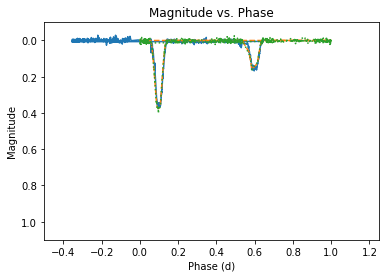

In [16]:
plt.plot(PhaseR - 0.355, magR - 0.025, '-', label = "V1061 data")
plt.plot(PhaseR, magnR, '--', label = "ellc simulation")
plt.plot (PhaseR, magnR_noise + 0.01, ':', label = "generated noise")

#ax.plot(Phase - 0.355, mag - 0.025, color='c', linestyle = '-,' label="V1061 data")
#ax.plot(Phase, magn, color='indigo', linestyle = '--', label="ellc simulation")


plt.title('Magnitude vs. Phase' )
#plt.legend()
#plt.xlim([-0.50,1.50])
#plt.ylim([1.1,-0.1])
plt.xlim([-0.50,1.25])
plt.ylim([1.1,-0.1])

#ymin=float(min(mag))
#ymax=float(max(mag))
#plt.ylim(ymax, ymin)


plt.ylabel('Magnitude')
plt.xlabel('Phase (d)')
plt.show()

In [17]:
## I-band
# phase-folded at 
#                http://vizier.cfa.harvard.edu/viz-bin/vizExec/Vgraph?J/ApJ/640/1018/./table7&P=2.35

In [18]:
I = pd.read_csv('V1061GettysburgI.csv', sep=",", header=0)
#X = pd.read_csv('V1061.csv', sep=",", header=0 )
HJDI = I["HJD"]
magI = I["Delmag"]
print (I)

             HJD  Delmag
0    2452548.592   0.191
1    2452541.552   0.187
2    2452548.594   0.190
3    2452541.555   0.172
4    2452548.596   0.185
5    2452548.598   0.182
6    2452541.561   0.185
7    2452548.601   0.174
8    2452548.603   0.172
9    2452541.564   0.180
10   2452548.605   0.176
11   2452541.567   0.185
12   2452548.608   0.179
13   2452541.571   0.185
14   2452541.574   0.181
15   2452548.616   0.165
16   2452541.577   0.158
17   2452548.618   0.145
18   2452548.620   0.145
19   2452534.541   0.138
20   2452548.623   0.140
21   2452534.543   0.134
22   2452548.625   0.130
23   2452534.546   0.112
24   2452541.587   0.121
25   2452548.627   0.113
26   2452534.548   0.093
27   2452548.630   0.090
28   2452541.590   0.092
29   2452534.551   0.085
..           ...     ...
710  2452548.521  -0.065
711  2452569.642  -0.074
712  2452548.524  -0.063
713  2452548.526  -0.045
714  2452569.646  -0.049
715  2452548.529  -0.055
716  2452548.531  -0.042
717  2452548.536  -0.009


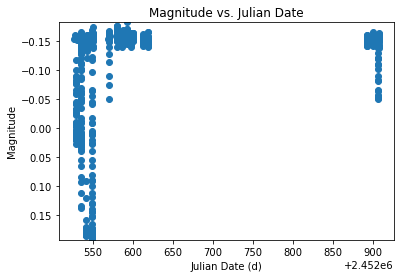

In [19]:
plt.plot (HJDI[1:], magI[1:], 'o')
plt.title ('Magnitude vs. Julian Date')
ymin=float(min(magI[1:]))
ymax=float(max(magI[1:]))
plt.ylim(ymax, ymin)
plt.xlabel('Julian Date (d)')
plt.ylabel ('Magnitude')

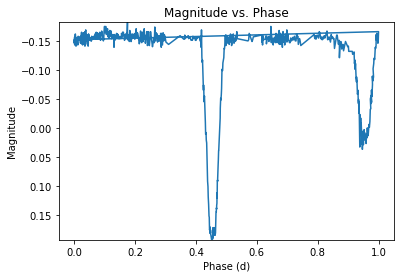

In [20]:
Period = 2.34665473 #days
PhaseI = (HJDI % Period)/ Period

plt.plot (PhaseI, magI, '-')
plt.title ('Magnitude vs. Phase')
ymin=float(min(magI))
ymax=float(max(magI))
plt.ylim(ymax, ymin)
plt.xlabel('Phase (d)')
plt.ylabel ('Magnitude')



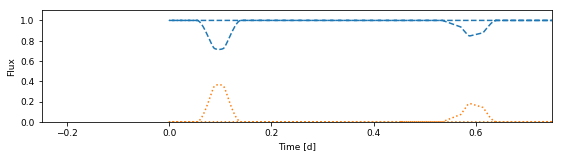

In [21]:
#M_H == 0
#Teff1 == 6180
#Teff2 == 5300
#logg1 == 4.129
#logg2 == 4.430

ldy_I = ellc.ldy.LimbGravityDarkeningCoeffs('I')
a1_1, a2_1, a3_1, a4_1, y = ldy_I(6180, 4.129, 0)
a1_2, a2_2, a3_2, a4_2, y = ldy_I(5300, 4.430, 0)


# Note that star 1 is the star labelled Secondary in nightfall
It_zero = 2452526.633
period = 2.34665473
Isbratio = 0.590
Ir_1 = 0.1648 
Ir_2 = 0.0994
Iincl = 88.3
light_3 = 0.156
a = 9.681
q = 0.7266
rotfac_1 = 1
rotfac_2 = 1
shape_1 = 'sphere'
shape_2 = 'sphere'
gdc_1 = -0.33
gdc_2 = -0.41
vsini_1 = 36
vsini_2 = 20
ld_1 = 'claret'
Ildc_1 = [a1_1, a2_1, a3_1, a4_1] #[0.35] 
ld_2 = 'claret'
Ildc_2 = [a1_2, a2_2, a3_2, a4_2] #[0.42] 
ecc = 0  # e>0 does not work in nightfall!
om  = 90
f_c = np.sqrt(ecc)*np.cos(om*np.pi/180.)
f_s = np.sqrt(ecc)*np.sin(om*np.pi/180.)

It = PhaseI*period
lcI = ellc.lc(It,t_zero=It_zero, period=period, a=a, q=q,
    ld_1=ld_1,ldc_1=Ildc_1,ld_2=ld_2,ldc_2=Ildc_2,
    radius_1=Ir_1, radius_2=Ir_2,incl=Iincl,sbratio=Isbratio, 
    rotfac_1=rotfac_1, rotfac_2=rotfac_2, gdc_1=gdc_1, gdc_2=gdc_2,
    shape_1=shape_1,shape_2=shape_2, light_3=light_3, grid_1='default',grid_2='default') 

magnI = -2.5*np.log10(lcI)


fontsize=9
fig=plt.figure(1,figsize=(8,4))
fig=plt.figure(1)
plt.subplot(211)
plt.xlim([-0.25,0.75])
plt.ylim([0.0,1.1])
plt.plot(PhaseI, lcI, linestyle='--')
plt.plot(PhaseI,magnI,linestyle=':')
plt.xlabel("Time [d]",fontsize=fontsize)
plt.ylabel("Flux",fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)


plt.tight_layout()
plt.show()

In [22]:
noiseI = np.random.normal(-0.0071, 0.0071, 740)
magnI_noise = magnI + noiseI

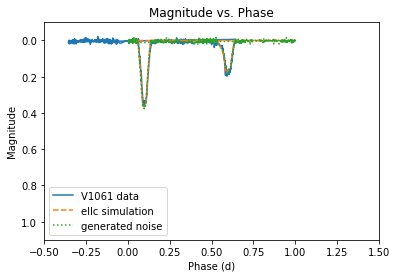

In [23]:
plt.plot(PhaseI - 0.355, magI + 0.16, '-', label = "V1061 data")
plt.plot(PhaseI, magnI, '--', label = "ellc simulation")
plt.plot (PhaseI, magnI_noise + 0.01, ':', label = "generated noise")

#ax.plot(Phase - 0.355, mag - 0.025, color='c', linestyle = '-,' label="V1061 data")
#ax.plot(Phase, magn, color='indigo', linestyle = '--', label="ellc simulation")


plt.title('Magnitude vs. Phase' )
plt.legend()
plt.xlim([-0.50,1.50])
plt.ylim([1.1,-0.1])

#ymin=float(min(mag))
#ymax=float(max(mag))
#plt.ylim(ymax, ymin)


plt.ylabel('Magnitude')
plt.xlabel('Phase (d)')
plt.show()

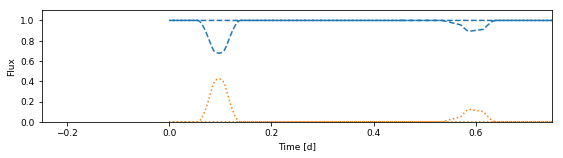

In [24]:
#M_H == 0
#Teff1 == 6180
#Teff2 == 5300
#logg1 == 4.129
#logg2 == 4.430

ldy_B = ellc.ldy.LimbGravityDarkeningCoeffs('B')
a1_1, a2_1, a3_1, a4_1, y = ldy_B(6180, 4.129, 0)
a1_2, a2_2, a3_2, a4_2, y = ldy_B(5300, 4.430, 0)


# Note that star 1 is the star labelled Secondary in nightfall
Bt_zero = 2452526.633
period = 2.34665473
Bsbratio = 0.398
Br_1 = 0.1635 
Br_2 = 0.0959
Bincl = 89.1
light_3 = 0.137
a = 9.681
q = 0.7266
rotfac_1 = 1
rotfac_2 = 1
shape_1 = 'sphere'
shape_2 = 'sphere'
gdc_1 = -0.33
gdc_2 = -0.41
vsini_1 = 36
vsini_2 = 20
ld_1 = 'claret'
Bldc_1 = [a1_1, a2_1, a3_1, a4_1] #[0.74] 
ld_2 = 'claret'
Bldc_2 = [a1_2, a2_2, a3_2, a4_2] #[0.83] 
ecc = 0  # e>0 does not work in nightfall!
om  = 90
f_c = np.sqrt(ecc)*np.cos(om*np.pi/180.)
f_s = np.sqrt(ecc)*np.sin(om*np.pi/180.)

Vt = PhaseV*period
lcB = ellc.lc(Vt,t_zero=Bt_zero, period=period, a=a, q=q,
    ld_1=ld_1,ldc_1=Bldc_1,ld_2=ld_2,ldc_2=Bldc_2,
    radius_1=Br_1, radius_2=Br_2,incl=Bincl,sbratio=Bsbratio, 
    rotfac_1=rotfac_1, rotfac_2=rotfac_2, gdc_1=gdc_1, gdc_2=gdc_2,
    shape_1=shape_1,shape_2=shape_2, light_3=light_3, grid_1='default',grid_2='default') 

magnB = -2.5*np.log10(lcB)


fontsize=9
fig=plt.figure(1,figsize=(8,4))
fig=plt.figure(1)
plt.subplot(211)
plt.xlim([-0.25,0.75])
plt.ylim([0.0,1.1])
plt.plot(PhaseV, lcB, linestyle='--')
plt.plot(PhaseV,magnB, linestyle=':')
plt.xlabel("Time [d]",fontsize=fontsize)
plt.ylabel("Flux",fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)


plt.tight_layout()
plt.show()

In [25]:
noiseB = np.random.normal(-0.0071, 0.0071, 738)
magnB_noise = magnB + noiseB

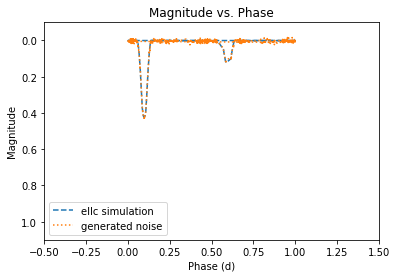

In [26]:
plt.plot(PhaseV, magnB, '--', label = "ellc simulation")
plt.plot (PhaseV, magnB_noise + 0.01, ':', label = "generated noise")

#ax.plot(Phase - 0.355, mag - 0.025, color='c', linestyle = '-,' label="V1061 data")
#ax.plot(Phase, magn, color='indigo', linestyle = '--', label="ellc simulation")


plt.title('Magnitude vs. Phase' )
plt.legend()
plt.xlim([-0.50,1.50])
plt.ylim([1.1,-0.1])

#ymin=float(min(mag))
#ymax=float(max(mag))
#plt.ylim(ymax, ymin)


plt.ylabel('Magnitude')
plt.xlabel('Phase (d)')
plt.show()

In [27]:
## Condensation of above phase-folded light curves by band, theoretical and real data

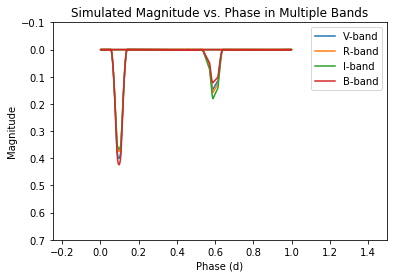

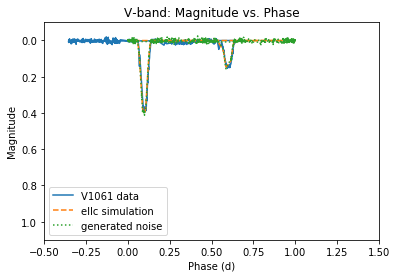

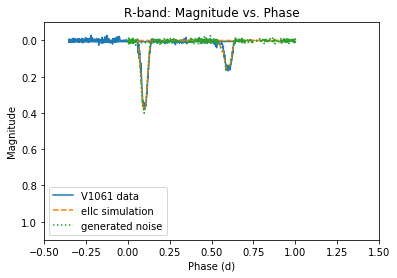

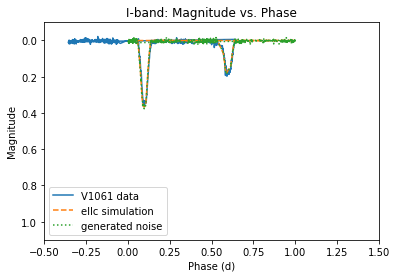

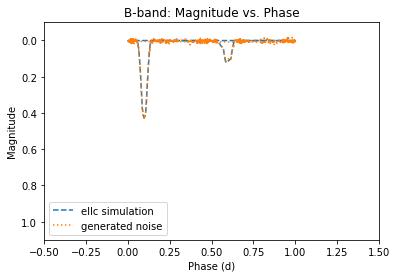

In [32]:
plt.plot(PhaseV, magnV, label = "V-band")
plt.plot(PhaseR, magnR, label = "R-band")
plt.plot(PhaseI, magnI, label = "I-band")
plt.plot(PhaseV, magnB, label = "B-band")

plt.title('Simulated Magnitude vs. Phase in Multiple Bands' )
plt.legend()
plt.xlim([-0.25,1.50])
plt.ylim([0.7,-0.1])
plt.ylabel('Magnitude')
plt.xlabel('Phase (d)')
plt.show()

plt.plot(PhaseV - 0.355, magV - 0.2, '-', label = "V1061 data")
plt.plot(PhaseV, magnV, '--', label = "ellc simulation")
plt.plot (PhaseV, magnV_noise, ':', label = "generated noise")
plt.title('V-band: Magnitude vs. Phase' )
plt.legend()
plt.xlim([-0.50,1.50])
plt.ylim([1.1,-0.1])
plt.ylabel('Magnitude')
plt.xlabel('Phase (d)')
plt.show()

plt.plot(PhaseR - 0.355, magR - 0.025, '-', label = "V1061 data")
plt.plot(PhaseR, magnR, '--', label = "ellc simulation")
plt.plot (PhaseR, magnR_noise + 0.01, ':', label = "generated noise")
plt.title('R-band: Magnitude vs. Phase' )
plt.legend()
plt.xlim([-0.50,1.50])
plt.ylim([1.1,-0.1])
plt.ylabel('Magnitude')
plt.xlabel('Phase (d)')
plt.show()

plt.plot(PhaseI - 0.355, magI + 0.16, '-', label = "V1061 data")
plt.plot(PhaseI, magnI, '--', label = "ellc simulation")
plt.plot (PhaseI, magnI_noise + 0.01, ':', label = "generated noise")
plt.title('I-band: Magnitude vs. Phase' )
plt.legend()
plt.xlim([-0.50,1.50])
plt.ylim([1.1,-0.1])
plt.ylabel('Magnitude')
plt.xlabel('Phase (d)')
plt.show()

plt.plot(PhaseV, magnB, '--', label = "ellc simulation")
plt.plot (PhaseV, magnB_noise + 0.01, ':', label = "generated noise")
plt.title('B-band: Magnitude vs. Phase' )
plt.legend()
plt.xlim([-0.50,1.50])
plt.ylim([1.1,-0.1])
plt.ylabel('Magnitude')
plt.xlabel('Phase (d)')
plt.show()

In [29]:
## Lomb-Scargle Periodogram with gatspy

In [30]:
filts = ['V', 'R', 'I', 'B']

periods = np.linspace[0.2, 5.5, 1000]
model = periodic.NaiveMultiband(BaseModel=periodic.LombScargleFast)
model.fit(t, mags, dy, filts)
P = model.scores(periods)

TypeError: 'function' object is not subscriptable